# Experiments with Tsinghua Dogs Dataset
- Parallel Visual Attention Encoder for Model Improvement (FerNet)
- EfficientNetB2

## Import libraries

In [1]:
# Import libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mping
import pandas as pd
import random

In [2]:
# Create function to ploss accuracy and loss
def plotModelsCurves(history, fine_tuned_history, model_name):
    epochs = len(history.history["loss"]+fine_tuned_history.history["loss"])
    plt.figure(figsize=(20,8))

    plt.subplot(1,2, 1)
    plt.title("Loss")
    plt.plot(range(epochs), history.history["loss"]+fine_tuned_history.history["loss"],color="blue", label="Train Loss")
    plt.plot(range(epochs), history.history["val_loss"]+fine_tuned_history.history["val_loss"], color="green", label="Val Loss")
    plt.axvline(x = len(history.history["loss"]), color = 'red', label = 'Fine Tuning')    
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1,2, 2)
    plt.title("Accuracy")
    plt.plot(range(epochs), history.history["accuracy"]+fine_tuned_history.history["accuracy"],color="blue", label="Train Loss")
    plt.plot(range(epochs), history.history["val_accuracy"]+fine_tuned_history.history["val_accuracy"], color="green", label="Val Loss")
    plt.axvline(x = len(history.history["accuracy"]), color = 'red', label = 'Fine Tuning')    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.suptitle(f'{model_name}', fontsize=18);
    plt.tight_layout()

    plt.plot()

## Load dataset

In [3]:
# Load images
seed = 42
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

    IMG_SIZE = (260,260)
    dataset_path = "/kaggle/input/tsinghua-dataset-low-resolution/TsinghuaLowRes"
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.20,
        subset="training",
        seed=seed,
        image_size=IMG_SIZE,
        batch_size=32,
        label_mode = 'categorical')
    train_ds = train_ds.with_options(options)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.20,
        subset="validation",
        seed=seed,
        image_size=IMG_SIZE,
        batch_size=32,
        label_mode = 'categorical')
    class_names_array = val_ds.class_names; num_outputs = len(val_ds.class_names); val_ds = val_ds.with_options(options)

2022-12-19 13:04:20.594034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:04:20.595068: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:04:20.907630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:04:20.908530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-19 13:04:20.909411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 70432 files belonging to 130 classes.
Using 56346 files for training.
Found 70432 files belonging to 130 classes.
Using 14086 files for validation.


##  Parallel Visual Attention Encoder for Model Improvement - FerNet

In [8]:
# fix random seed for reproducibility
tf.random.set_seed(0)
with strategy.scope():
    
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Inputs")

    ## EfficientNet
    effNet_model = base_model(inputs, training=False)
    
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    eff_model = tf.keras.Model(inputs=inputs, outputs=effNet_model, name="EfficientNetB2")

    ## Visual Attention
    va = tf.keras.layers.Rescaling(1/255., name="Rescaling")(inputs)
    
    va = tf.keras.layers.Conv2D(32, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention1")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    va = tf.keras.layers.Conv2D(16, 3, activation=tf.keras.activations.gelu, strides=1, name="ConvEnconderAttention2")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    # LKA    
    va_input = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector1')(va)
    va1 = tf.keras.layers.BatchNormalization()(va_input)
    va1 = tf.keras.layers.Activation(tf.keras.activations.gelu)(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(5, padding='same',name='LKA_DWProjector_Spatial1')(va1)
    va1 = tf.keras.layers.DepthwiseConv2D(7, padding='same', dilation_rate=3, name='LKA_DWProjector_Spatial2')(va1)
    va1 = tf.keras.layers.Conv2D(4, 1, name='LKA_Projector2')(va1)
    va1 = tf.keras.layers.Conv2D(12, 1, name='LKA_Projector3')(va1)
    va1 = tf.keras.layers.Add()([va1, va_input])
    # CBAM
    ## Channel Attention
    input_channels = va.get_shape()[-1]
    avg_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=[1,2], keepdims=True))(va)
    max_pool_channel = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=[1,2], keepdims=True))(va)
    avg_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv1")(avg_pool_channel)
    avg_pool_channel = tf.keras.layers.Dense(input_channels,
                                             kernel_initializer='he_normal',use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Avg_Conv2")(avg_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels//3,
                                             activation="relu", kernel_initializer='he_normal',
                                             use_bias=True,
                                             bias_initializer='zeros', name="ChannelAtt_Max_Conv1")(max_pool_channel)
    max_pool_channel = tf.keras.layers.Dense(input_channels,
                                     kernel_initializer='he_normal',
                                     use_bias=True,
                                     bias_initializer='zeros', name="ChannelAtt_Max_Conv2")(max_pool_channel)
    channel_attention = tf.keras.layers.Add()([avg_pool_channel,max_pool_channel])
    channel_attention = tf.keras.layers.Activation("sigmoid")(channel_attention)
    channel_attention = tf.keras.layers.Multiply()([va, channel_attention])

    ## Spatial attention
    kernel_size = 7
    avg_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(channel_attention)
    max_pool_spatial = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(channel_attention)
    
    spatial_attention = tf.keras.layers.Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])
    spatial_attention = tf.keras.layers.Conv2D(filters = 1,
                                        kernel_size=kernel_size,
                                        strides=1,
                                        padding='same',
                                        activation= tf.keras.activations.sigmoid,
                                        kernel_initializer='he_normal',
                                        use_bias=False,name="SpatialAtt_Max_Conv2")(spatial_attention)
    spatial_attention = tf.keras.layers.multiply([channel_attention, spatial_attention])
    
    # Unify modules - Latent space
    va1 = tf.keras.layers.Conv2D(4, kernel_size=1)(va1)
    va2 = tf.keras.layers.Conv2D(4, kernel_size=1)(spatial_attention)
    va = tf.keras.layers.Add()([va1, va2])

    va = tf.keras.layers.Conv2D(4, kernel_size=5, strides=2,activation=tf.keras.activations.gelu, name="latent_output")(va)
    va = tf.keras.layers.AveragePooling2D()(va)
    
    va_pooling = tf.keras.layers.Flatten()(va)   
    
    # Create module
    va_model = tf.keras.Model(inputs=inputs, outputs=va_pooling)

    # Concatenate with base model
    embedded_model = tf.keras.layers.Concatenate(name="EmbeddingLayer")([eff_model.output, va_model.output])
    #embedded_model = tf.keras.layers.Dense(512, activation="relu")(embedded_model)
    embedded_model = tf.keras.layers.Dropout(rate=0.5,name="DropoutToOutput")(embedded_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation="softmax", name="Output_layer")(embedded_model)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="FerNet")

    model.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])

In [9]:
model.summary()

Model: "FerNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Inputs (InputLayer)             [(None, 260, 260, 3) 0                                            
__________________________________________________________________________________________________
Rescaling (Rescaling)           (None, 260, 260, 3)  0           Inputs[0][0]                     
__________________________________________________________________________________________________
ConvEnconderAttention1 (Conv2D) (None, 258, 258, 32) 896         Rescaling[0][0]                  
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 129, 129, 32) 0           ConvEnconderAttention1[0][0]     
_____________________________________________________________________________________________

In [10]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=3, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")

initial_epochs = 10
FerNetHistory = model.fit(train_ds,
                           epochs=initial_epochs,
                           steps_per_epoch=len(train_ds),
                           validation_data = val_ds,
                           callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/10
 536/1761 [========>.....................] - ETA: 3:26 - loss: 1.5429 - accuracy: 0.6806

Cleanup called...


1761/1761 [==============================] - 373s 200ms/step - loss: 1.1100 - accuracy: 0.7556 - val_loss: 0.8422 - val_accuracy: 0.8127

Epoch 00001: val_accuracy improved from -inf to 0.81265, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 2/10
 536/1761 [========>.....................] - ETA: 3:29 - loss: 0.8430 - accuracy: 0.8107

Cleanup called...


1761/1761 [==============================] - 351s 199ms/step - loss: 0.8384 - accuracy: 0.8108 - val_loss: 0.8235 - val_accuracy: 0.8167

Epoch 00002: val_accuracy improved from 0.81265 to 0.81670, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 3/10
 536/1761 [========>.....................] - ETA: 3:26 - loss: 0.7950 - accuracy: 0.8243

Cleanup called...


1761/1761 [==============================] - 345s 196ms/step - loss: 0.7966 - accuracy: 0.8227 - val_loss: 0.8208 - val_accuracy: 0.8169

Epoch 00003: val_accuracy improved from 0.81670 to 0.81691, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 4/10
 536/1761 [========>.....................] - ETA: 3:26 - loss: 0.7632 - accuracy: 0.8341

Cleanup called...


1761/1761 [==============================] - 349s 198ms/step - loss: 0.7671 - accuracy: 0.8319 - val_loss: 0.8212 - val_accuracy: 0.8161

Epoch 00004: val_accuracy did not improve from 0.81691
Epoch 5/10
 536/1761 [========>.....................] - ETA: 3:26 - loss: 0.7423 - accuracy: 0.8425

Cleanup called...


1761/1761 [==============================] - 377s 214ms/step - loss: 0.7492 - accuracy: 0.8384 - val_loss: 0.8273 - val_accuracy: 0.8187

Epoch 00005: val_accuracy improved from 0.81691 to 0.81869, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 6/10
 536/1761 [========>.....................] - ETA: 3:27 - loss: 0.7308 - accuracy: 0.8457

Cleanup called...


1761/1761 [==============================] - 348s 197ms/step - loss: 0.7336 - accuracy: 0.8440 - val_loss: 0.8331 - val_accuracy: 0.8174

Epoch 00006: val_accuracy did not improve from 0.81869
Epoch 7/10
 536/1761 [========>.....................] - ETA: 3:27 - loss: 0.7137 - accuracy: 0.8524

Cleanup called...


1761/1761 [==============================] - 381s 216ms/step - loss: 0.7181 - accuracy: 0.8496 - val_loss: 0.8373 - val_accuracy: 0.8165

Epoch 00007: val_accuracy did not improve from 0.81869
Epoch 8/10
 536/1761 [========>.....................] - ETA: 3:27 - loss: 0.7051 - accuracy: 0.8514

Cleanup called...


1761/1761 [==============================] - 347s 197ms/step - loss: 0.7095 - accuracy: 0.8508 - val_loss: 0.8380 - val_accuracy: 0.8167

Epoch 00008: val_accuracy did not improve from 0.81869

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 9/10
 536/1761 [========>.....................] - ETA: 3:26 - loss: 0.7029 - accuracy: 0.8547

Cleanup called...


1761/1761 [==============================] - 343s 195ms/step - loss: 0.6778 - accuracy: 0.8639 - val_loss: 0.8314 - val_accuracy: 0.8197

Epoch 00009: val_accuracy improved from 0.81869 to 0.81968, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 10/10
 536/1761 [========>.....................] - ETA: 3:27 - loss: 0.6927 - accuracy: 0.8577

Cleanup called...


1761/1761 [==============================] - 344s 195ms/step - loss: 0.6705 - accuracy: 0.8653 - val_loss: 0.8294 - val_accuracy: 0.8212

Epoch 00010: val_accuracy improved from 0.81968 to 0.82124, saving model to /pechpoints_weights/checkpoint.ckpt


### Base Model Fine tuning (last 10% layers)

In [12]:
model.load_weights(checkpoint_path) # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=6, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(FerNetHistory.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+10

    FerNet_fine_tuned = model.fit(train_ds,
                                  epochs=fine_tune_epochs,
                                  initial_epoch= FerNetHistory.epoch[-1]+1,
                                  validation_data = val_ds,
                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 11/20
 537/1761 [========>.....................] - ETA: 3:47 - loss: 0.2876 - accuracy: 0.8994

Cleanup called...


1761/1761 [==============================] - 404s 217ms/step - loss: 0.2788 - accuracy: 0.9010 - val_loss: 0.5821 - val_accuracy: 0.8279

Epoch 00011: val_accuracy did not improve from 0.82941
Epoch 12/20
 536/1761 [========>.....................] - ETA: 3:48 - loss: 0.2735 - accuracy: 0.9029

Cleanup called...


1761/1761 [==============================] - 378s 215ms/step - loss: 0.2660 - accuracy: 0.9056 - val_loss: 0.5832 - val_accuracy: 0.8291

Epoch 00012: val_accuracy did not improve from 0.82941
Epoch 13/20
 537/1761 [========>.....................] - ETA: 3:45 - loss: 0.2599 - accuracy: 0.9106

Cleanup called...


1761/1761 [==============================] - 374s 212ms/step - loss: 0.2506 - accuracy: 0.9113 - val_loss: 0.5865 - val_accuracy: 0.8277

Epoch 00013: val_accuracy did not improve from 0.82941
Epoch 14/20
 536/1761 [========>.....................] - ETA: 3:46 - loss: 0.2465 - accuracy: 0.9116

Cleanup called...


1761/1761 [==============================] - 374s 212ms/step - loss: 0.2393 - accuracy: 0.9128 - val_loss: 0.5933 - val_accuracy: 0.8283

Epoch 00014: val_accuracy did not improve from 0.82941
Epoch 15/20
 536/1761 [========>.....................] - ETA: 3:45 - loss: 0.2338 - accuracy: 0.9167

Cleanup called...


1761/1761 [==============================] - 373s 212ms/step - loss: 0.2306 - accuracy: 0.9168 - val_loss: 0.5952 - val_accuracy: 0.8286

Epoch 00015: val_accuracy did not improve from 0.82941
Epoch 16/20
 536/1761 [========>.....................] - ETA: 3:43 - loss: 0.2237 - accuracy: 0.9221

Cleanup called...


1761/1761 [==============================] - 374s 212ms/step - loss: 0.2132 - accuracy: 0.9241 - val_loss: 0.5974 - val_accuracy: 0.8295

Epoch 00016: val_accuracy improved from 0.82941 to 0.82948, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 17/20
 536/1761 [========>.....................] - ETA: 3:47 - loss: 0.2215 - accuracy: 0.9194

Cleanup called...


1761/1761 [==============================] - 376s 213ms/step - loss: 0.2115 - accuracy: 0.9235 - val_loss: 0.5986 - val_accuracy: 0.8295

Epoch 00017: val_accuracy improved from 0.82948 to 0.82955, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 18/20
 536/1761 [========>.....................] - ETA: 3:45 - loss: 0.2137 - accuracy: 0.9248

Cleanup called...


1761/1761 [==============================] - 374s 212ms/step - loss: 0.2091 - accuracy: 0.9257 - val_loss: 0.5990 - val_accuracy: 0.8290

Epoch 00018: val_accuracy did not improve from 0.82955
Epoch 19/20
 536/1761 [========>.....................] - ETA: 3:45 - loss: 0.2184 - accuracy: 0.9207

Cleanup called...


1761/1761 [==============================] - 378s 214ms/step - loss: 0.2087 - accuracy: 0.9242 - val_loss: 0.6002 - val_accuracy: 0.8299

Epoch 00019: val_accuracy improved from 0.82955 to 0.82990, saving model to /pechpoints_weights/checkpoint.ckpt
Epoch 20/20
 536/1761 [========>.....................] - ETA: 3:45 - loss: 0.2139 - accuracy: 0.9220

Cleanup called...


1761/1761 [==============================] - 375s 213ms/step - loss: 0.2068 - accuracy: 0.9249 - val_loss: 0.5999 - val_accuracy: 0.8298

Epoch 00020: val_accuracy did not improve from 0.82990


### Save our best model

In [17]:
# load best weights
model.load_weights(checkpoint_path)
# Save model and load
model.save("TsinghuaFerNetEfficientNetB2")
FerNetEffNetB2Tsinghua = tf.keras.models.load_model("TsinghuaFerNetEfficientNetB2")
!zip -r TsinghuaFerNetEfficientNetB2.zip TsinghuaFerNetEfficientNetB2

2022-12-19 17:51:44.386210: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


  adding: TsinghuaFerNetEfficientNetB2/ (stored 0%)
  adding: TsinghuaFerNetEfficientNetB2/assets/ (stored 0%)
  adding: TsinghuaFerNetEfficientNetB2/variables/ (stored 0%)
  adding: TsinghuaFerNetEfficientNetB2/variables/variables.index (deflated 76%)
  adding: TsinghuaFerNetEfficientNetB2/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: TsinghuaFerNetEfficientNetB2/keras_metadata.pb (deflated 96%)
  adding: TsinghuaFerNetEfficientNetB2/saved_model.pb (deflated 91%)


In [19]:
print(f"Best Model Validation Accuracy: {FerNetEffNetB2Tsinghua.evaluate(val_ds, verbose=0)[1]}")

Best Model Validation Accuracy: 0.829831063747406


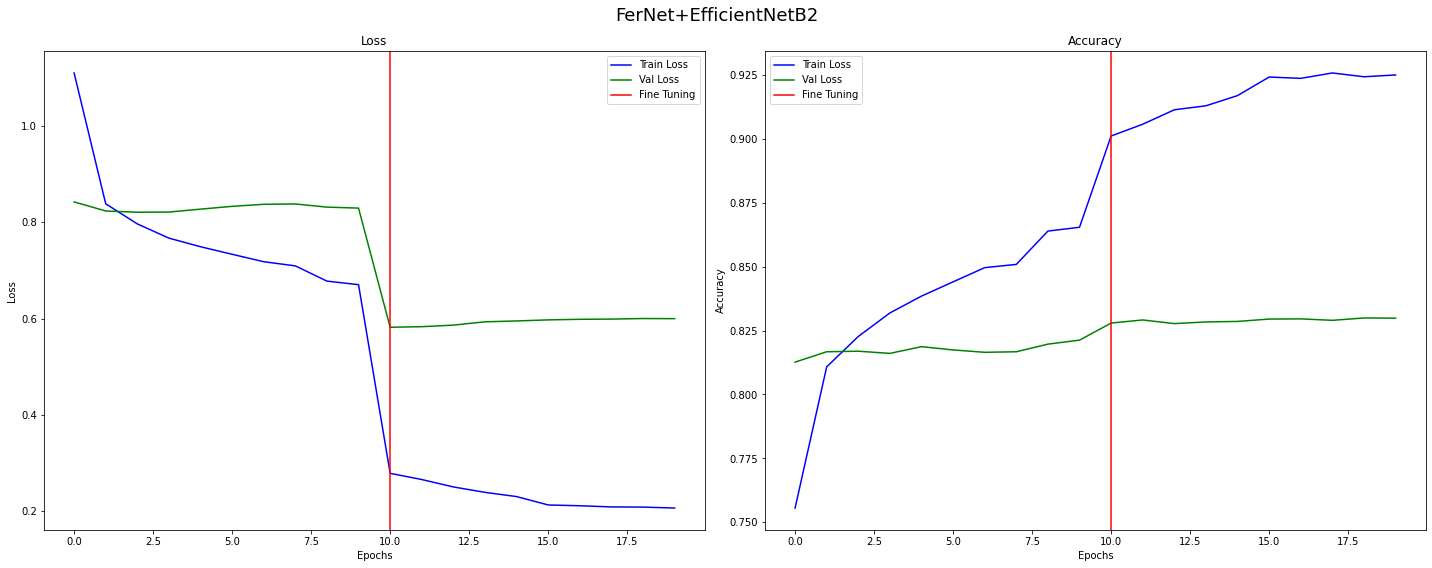

In [24]:
plotModelsCurves(FerNetHistory, FerNet_fine_tuned, model_name="FerNet+EfficientNetB2")

## EfficientNetB2 Alone

In [13]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetB2(include_top=False)
    base_model.trainable = False
    input_shape = IMG_SIZE+(3,)
    
    inputs = tf.keras.layers.Input(shape=input_shape, name="Input_layer")
    ## EfficientNetB2
    effNet_model = base_model(inputs, training=False)
    effNet_model = tf.keras.layers.GlobalAveragePooling2D()(effNet_model)
    effNet_model = tf.keras.layers.Dropout(rate=0.5,name="Dropout2")(effNet_model)
    outputs = tf.keras.layers.Dense(num_outputs, activation=tf.nn.softmax, name="Output_layer")(effNet_model)
    # Create model
    effb2 = tf.keras.Model(inputs=inputs, outputs=outputs)
    # Compile model
    effb2.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.025),
                  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
                  metrics=["accuracy"])
    effb2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 260, 260, 3)]     0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, None, None, 1408)  7768569   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
Dropout2 (Dropout)           (None, 1408)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 130)               183170    
Total params: 7,951,739
Trainable params: 183,170
Non-trainable params: 7,768,569
_________________________________________________________________


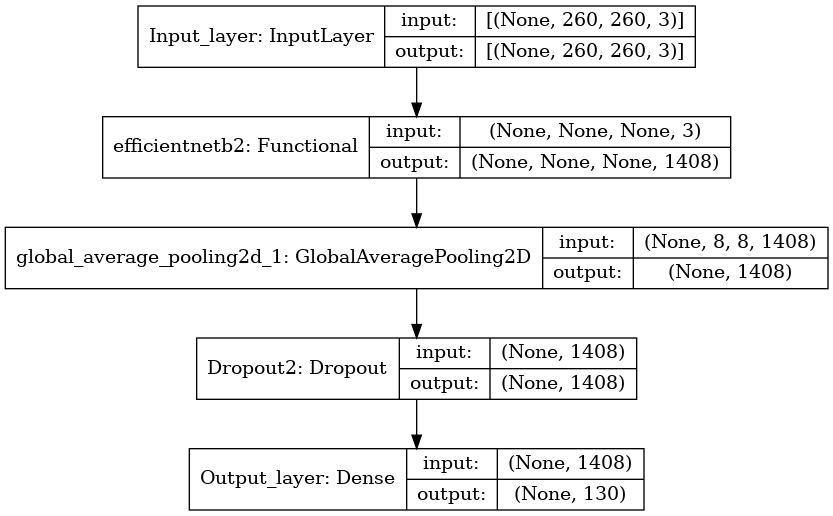

In [7]:
from tensorflow.keras.utils import plot_model
plot_model(effb2, show_shapes=True)

In [14]:
# Set checkpoint path
checkpoint_path = "/pechpoints_weights/checkpoint_effnetb2.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         verbose=1,
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq="epoch", monitor="val_accuracy")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.10,patience=4, verbose=1)

early_stopper = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
initial_epochs = 10
effb2History = effb2.fit(train_ds,
                           epochs=initial_epochs,
                           steps_per_epoch=len(train_ds),
                           validation_data = val_ds,
                           callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Epoch 1/10
 541/1761 [========>.....................] - ETA: 2:14 - loss: 1.5764 - accuracy: 0.6733

Cleanup called...


1761/1761 [==============================] - 263s 140ms/step - loss: 1.1283 - accuracy: 0.7514 - val_loss: 0.8435 - val_accuracy: 0.8104

Epoch 00001: val_accuracy improved from -inf to 0.81038, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 2/10
 541/1761 [========>.....................] - ETA: 2:18 - loss: 0.8496 - accuracy: 0.8100

Cleanup called...


1761/1761 [==============================] - 239s 135ms/step - loss: 0.8453 - accuracy: 0.8095 - val_loss: 0.8239 - val_accuracy: 0.8166

Epoch 00002: val_accuracy improved from 0.81038 to 0.81656, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 3/10
 541/1761 [========>.....................] - ETA: 2:08 - loss: 0.8094 - accuracy: 0.8187

Cleanup called...


1761/1761 [==============================] - 231s 131ms/step - loss: 0.8056 - accuracy: 0.8194 - val_loss: 0.8224 - val_accuracy: 0.8176

Epoch 00003: val_accuracy improved from 0.81656 to 0.81762, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 4/10
 541/1761 [========>.....................] - ETA: 2:04 - loss: 0.7801 - accuracy: 0.8293

Cleanup called...


1761/1761 [==============================] - 225s 128ms/step - loss: 0.7818 - accuracy: 0.8276 - val_loss: 0.8196 - val_accuracy: 0.8192

Epoch 00004: val_accuracy improved from 0.81762 to 0.81918, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 5/10
 541/1761 [========>.....................] - ETA: 2:07 - loss: 0.7642 - accuracy: 0.8340

Cleanup called...


1761/1761 [==============================] - 225s 127ms/step - loss: 0.7718 - accuracy: 0.8298 - val_loss: 0.8206 - val_accuracy: 0.8184

Epoch 00005: val_accuracy did not improve from 0.81918
Epoch 6/10
 541/1761 [========>.....................] - ETA: 2:05 - loss: 0.7619 - accuracy: 0.8346

Cleanup called...


1761/1761 [==============================] - 224s 127ms/step - loss: 0.7586 - accuracy: 0.8350 - val_loss: 0.8229 - val_accuracy: 0.8186

Epoch 00006: val_accuracy did not improve from 0.81918
Epoch 7/10
 541/1761 [========>.....................] - ETA: 2:06 - loss: 0.7543 - accuracy: 0.8336

Cleanup called...


1761/1761 [==============================] - 228s 129ms/step - loss: 0.7567 - accuracy: 0.8351 - val_loss: 0.8245 - val_accuracy: 0.8188

Epoch 00007: val_accuracy did not improve from 0.81918
Epoch 8/10
 541/1761 [========>.....................] - ETA: 2:05 - loss: 0.7489 - accuracy: 0.8383

Cleanup called...


1761/1761 [==============================] - 228s 129ms/step - loss: 0.7510 - accuracy: 0.8373 - val_loss: 0.8287 - val_accuracy: 0.8202

Epoch 00008: val_accuracy improved from 0.81918 to 0.82018, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt
Epoch 9/10
 541/1761 [========>.....................] - ETA: 2:08 - loss: 0.7379 - accuracy: 0.8417

Cleanup called...


1761/1761 [==============================] - 267s 151ms/step - loss: 0.7430 - accuracy: 0.8404 - val_loss: 0.8239 - val_accuracy: 0.8182

Epoch 00009: val_accuracy did not improve from 0.82018
Epoch 10/10
 540/1761 [========>.....................] - ETA: 2:13 - loss: 0.7415 - accuracy: 0.8407

Cleanup called...


1761/1761 [==============================] - 237s 134ms/step - loss: 0.7444 - accuracy: 0.8402 - val_loss: 0.8297 - val_accuracy: 0.8202

Epoch 00010: val_accuracy improved from 0.82018 to 0.82025, saving model to /pechpoints_weights/checkpoint_effnetb2.ckpt


### Base Model Fine tuning (last 10% layers)

In [15]:
effb2.load_weights("/pechpoints_weights/checkpoint_effnetb2.ckpt") # Load best weights

# Reinstantiate Callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,patience=4, verbose=0)
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, 
                                                 restore_best_weights=True,
                                                 monitor="val_accuracy")
with strategy.scope():
    # Unfreeze all of the layer in the base model
    base_model.trainable = True
    
    to_unfreeze = round(len(base_model.layers)*0.10)
    print(f"Trainable layers of our base model: {to_unfreeze}\n")
    # Refreeze every layer except the last 10%
    for layer in base_model.layers[:-to_unfreeze]:
        layer.trainable = False
    
    # Recompile model with lower learning rate (it's typically best practice to lower the learning rate when fine-tuning)
    effb2.compile(loss=tf.keras.losses.categorical_crossentropy,
                    optimizer= tf.keras.optimizers.Adam(effb2History.history['lr'][-1]*.1),
                    metrics=["accuracy"])

    fine_tune_epochs = initial_epochs+10

    fine_tuned_effb2History = effb2.fit(train_ds,
                                  epochs=fine_tune_epochs,
                                  initial_epoch= effb2History.epoch[-1]+1,
                                  validation_data = val_ds,
                                  callbacks=[checkpoint_callback, reduce_lr, early_stopper])

Trainable layers of our base model: 34

Epoch 11/20
 541/1761 [========>.....................] - ETA: 2:25 - loss: 0.4952 - accuracy: 0.8416

Cleanup called...


1761/1761 [==============================] - 276s 146ms/step - loss: 0.4708 - accuracy: 0.8490 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00011: val_accuracy did not improve from 0.82025
Epoch 12/20
 540/1761 [========>.....................] - ETA: 2:18 - loss: 0.4901 - accuracy: 0.8411

Cleanup called...


1761/1761 [==============================] - 244s 138ms/step - loss: 0.4696 - accuracy: 0.8472 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00012: val_accuracy did not improve from 0.82025
Epoch 13/20
 541/1761 [========>.....................] - ETA: 2:19 - loss: 0.4890 - accuracy: 0.8438

Cleanup called...


1761/1761 [==============================] - 245s 139ms/step - loss: 0.4666 - accuracy: 0.8506 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00013: val_accuracy did not improve from 0.82025
Epoch 14/20
 541/1761 [========>.....................] - ETA: 2:22 - loss: 0.4935 - accuracy: 0.8405

Cleanup called...


1761/1761 [==============================] - 249s 141ms/step - loss: 0.4685 - accuracy: 0.8495 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00014: val_accuracy did not improve from 0.82025
Epoch 15/20
 541/1761 [========>.....................] - ETA: 2:19 - loss: 0.4976 - accuracy: 0.8423

Cleanup called...


1761/1761 [==============================] - 246s 140ms/step - loss: 0.4724 - accuracy: 0.8485 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00015: val_accuracy did not improve from 0.82025
Epoch 16/20
 541/1761 [========>.....................] - ETA: 2:20 - loss: 0.4925 - accuracy: 0.8444

Cleanup called...


1761/1761 [==============================] - 246s 139ms/step - loss: 0.4705 - accuracy: 0.8499 - val_loss: 0.5890 - val_accuracy: 0.8202

Epoch 00016: val_accuracy did not improve from 0.82025


In [23]:
print(f"Best Model Validation Accuracy: {effb2.evaluate(val_ds, verbose=0)[1]}")

Best Model Validation Accuracy: 0.8202470541000366


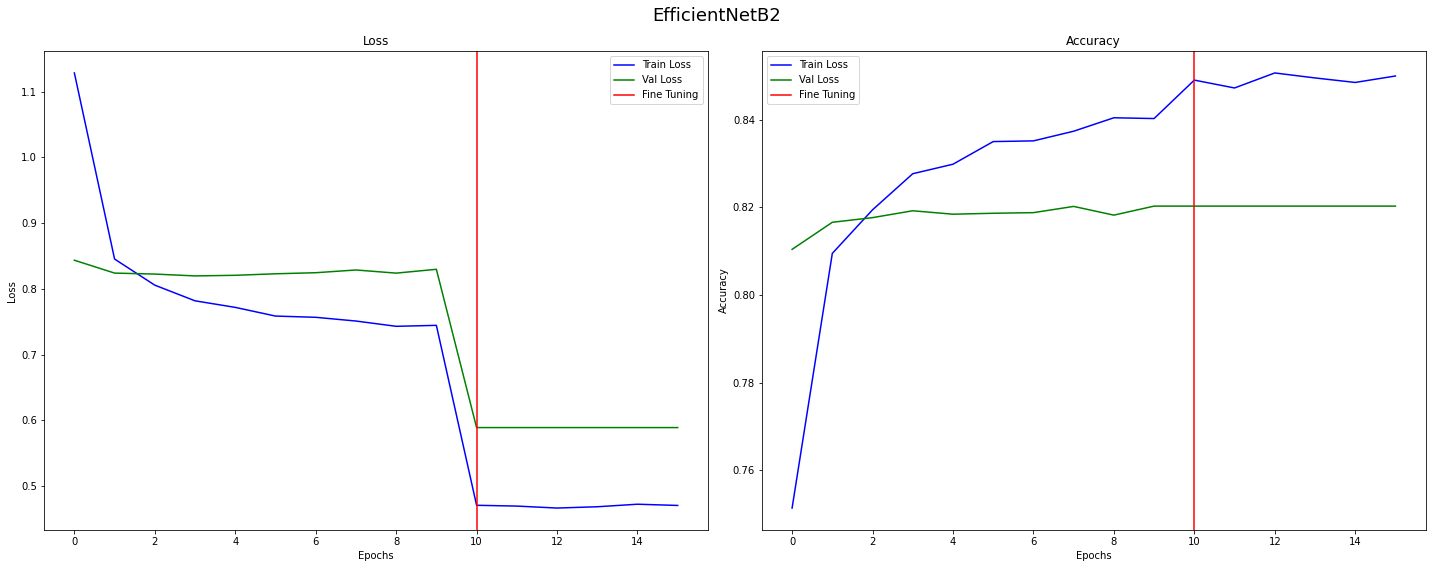

In [25]:
plotModelsCurves(effb2History, fine_tuned_effb2History, model_name="EfficientNetB2")